In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import datetime
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [71]:
csv_file = './SPX_Options.csv'
data = pd.read_csv(csv_file)
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
print(data.head())

X = data[['Moneyness', 'TTM', 'D_BS']].iloc[0:30]
y = data[['Delta Residual']].rename(columns={'Delta Residual': 'Residual'}).iloc[0:30]

print(f'\n\nFeatures:\n {X.describe()} \n\n\n Test data:\n {y.describe()}')

(1020, 14)
(1008, 14)
         Date  ID  Days until next hedge        S  Dividend        C_BS  \
0  2024/08/05   1                      1  5186.33    1.4816  125.615076   
1  2024/08/06   1                      1  5240.03    1.4665  120.416043   
2  2024/08/07   1                      1  5199.50    1.4786  106.223538   
3  2024/08/08   1                      1  5319.31    1.4450  139.557618   
4  2024/08/09   1                      3  5344.16    1.4383  134.699810   

       D_BS   C_mkt  D_Blm        R  TTM  Moneyness  D_Optimal  Delta Residual  
0  0.308576  147.20  0.339  4.95853  228       -514  -0.398225       -0.706801  
1  0.317215  125.90  0.330  4.95203  227       -460   0.344879        0.027664  
2  0.291429  111.85  0.312  4.85962  226       -501   0.350350        0.058922  
3  0.357376  153.75  0.380  4.95040  225       -381  -0.332813       -0.690190  
4  0.362407  145.55  0.379  4.97276  224       -356   2.613517        2.251110  


Features:
         Moneyness         TT

        Moneyness         TTM       D_BS
count   30.000000   30.000000  30.000000
mean  -197.966667  208.033333   0.464244
std    135.557211   12.831758   0.080030
min   -514.000000  186.000000   0.291429
25%   -260.750000  197.250000   0.420408
50%   -151.500000  208.500000   0.489596
75%    -94.750000  218.750000   0.533611
max    -52.000000  228.000000   0.559052

Skew: 
Moneyness   -1.081741
TTM         -0.071494
D_BS        -0.805035
dtype: float64

Kurtosis: 
Moneyness    0.175498
TTM         -1.225343
D_BS        -0.538168
dtype: float64


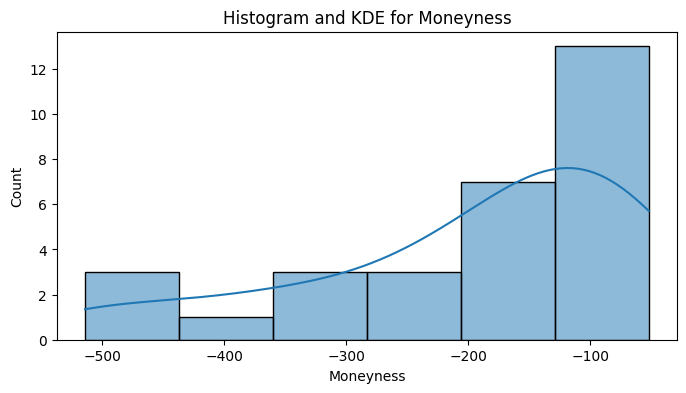

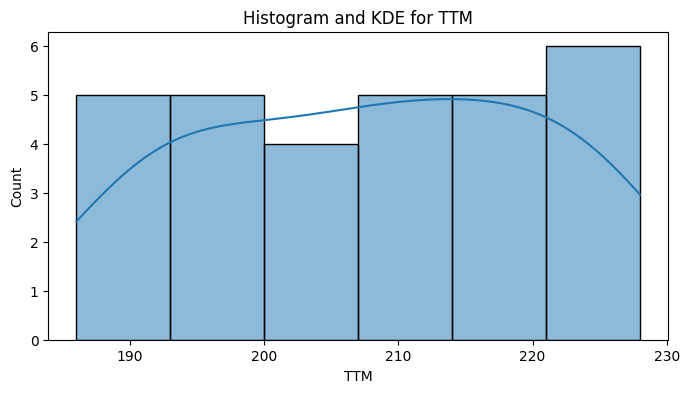

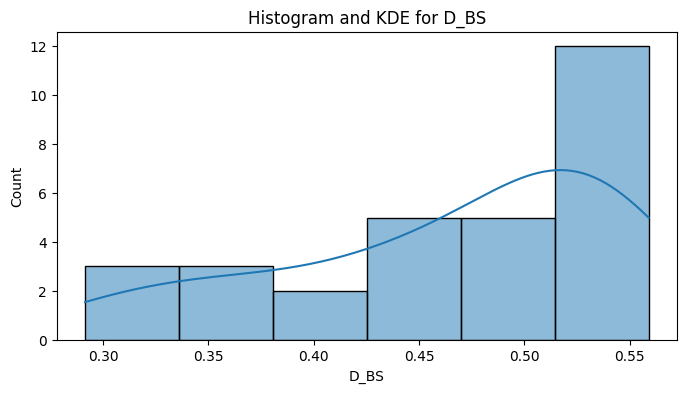

        Residual
count  30.000000
mean   -0.631289
std     4.602374
min   -24.437519
25%    -0.148515
50%     0.010997
75%     0.102103
max     4.706274

Skew: 
Residual   -5.043559
dtype: float64

Kurtosis: 
Residual    27.113248
dtype: float64


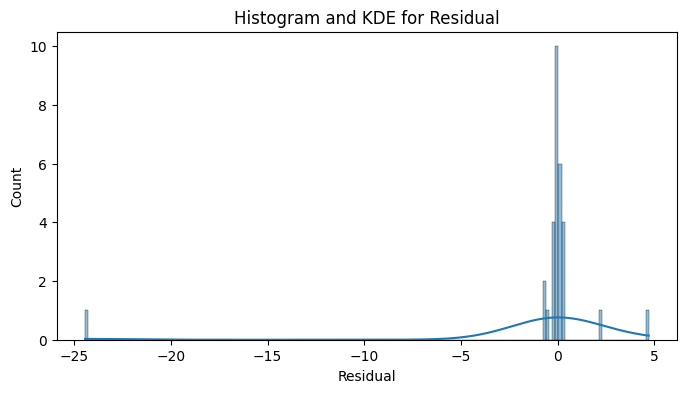

In [72]:
def describe_data(df):
    print(df.describe())
    print("\nSkew: ")
    print(df.skew())
    print("\nKurtosis: ")
    print(df.kurtosis())
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram and KDE for {column}')
        plt.show()

describe_data(X)
describe_data(y)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [74]:
def plot_train_test(train, test):
    columns = train.columns.tolist()
    for column in columns:
        plt.hist(train[column], bins=30, alpha=0.5
                 , label=f'Training data for {column}')
        plt.hist(test[column], bins=30, alpha=0.5, label=f'Test data for {column}')
        plt.legend()
        plt.title(f'Distribution of {column}')
        plt.show()


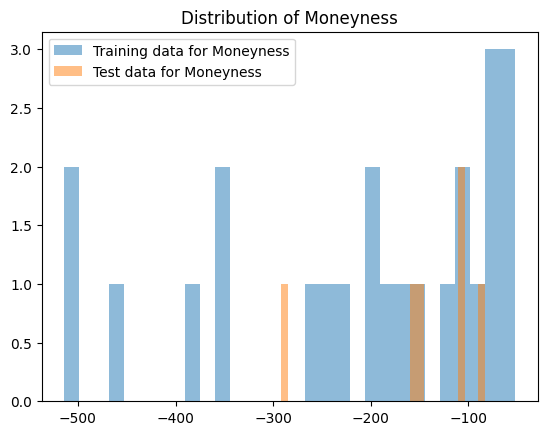

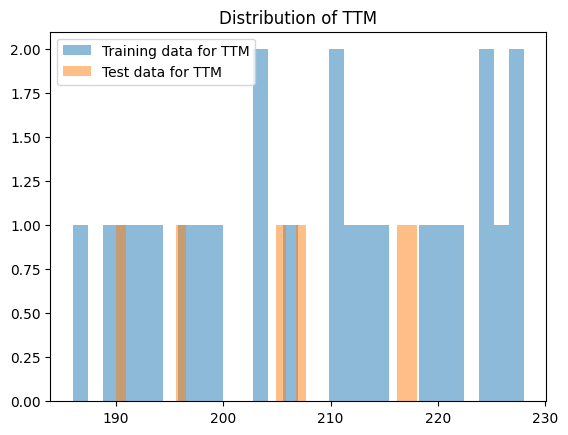

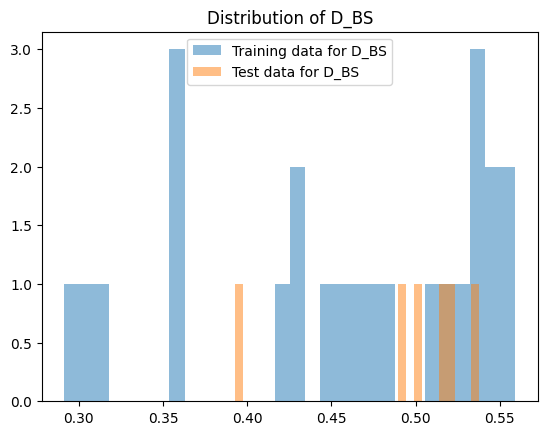

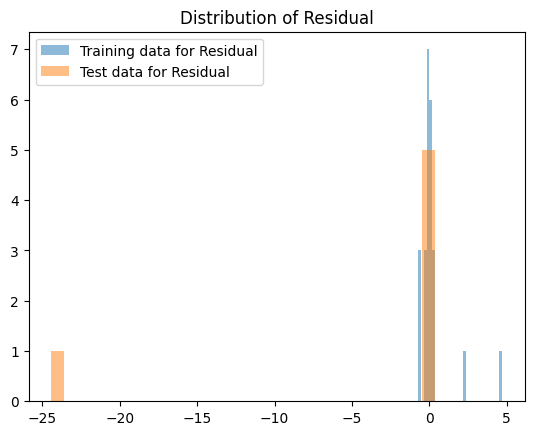

In [75]:
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")
plot_train_test(y_train, y_test)

In [76]:
scaler = MinMaxScaler()

datasets = {
    "X_train": X_train,
    "X_test": X_test,
}

for key in datasets:
    datasets[key] = scaler.fit_transform(datasets[key])

feat_cols = ['Moneyness', 'TTM', 'D_BS']
target_cols = ['Residual']

X_train = pd.DataFrame(datasets["X_train"], columns=feat_cols)
X_test = pd.DataFrame(datasets["X_test"], columns=feat_cols)

X_train.to_csv('./X_train.csv')
y_train.to_csv('./y_train.csv')
X_test.to_csv('./X_test.csv')
y_test.to_csv('./y_test.csv')

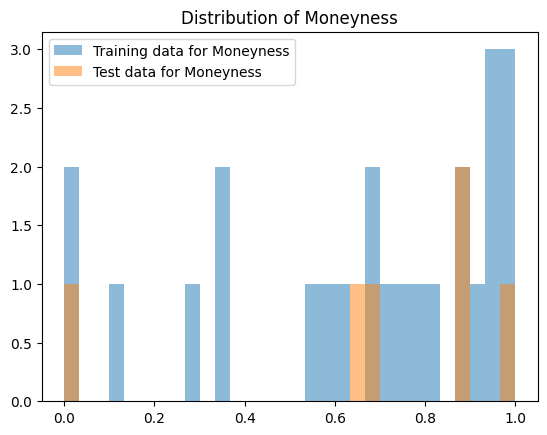

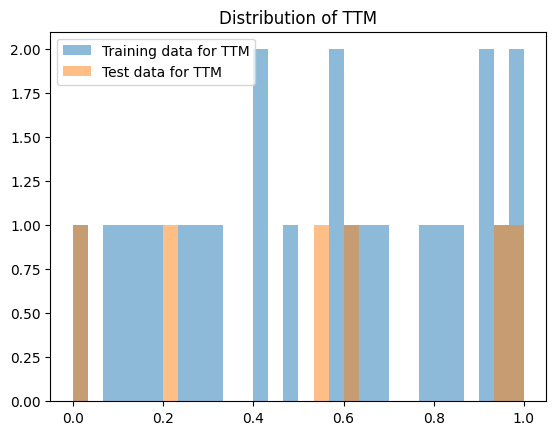

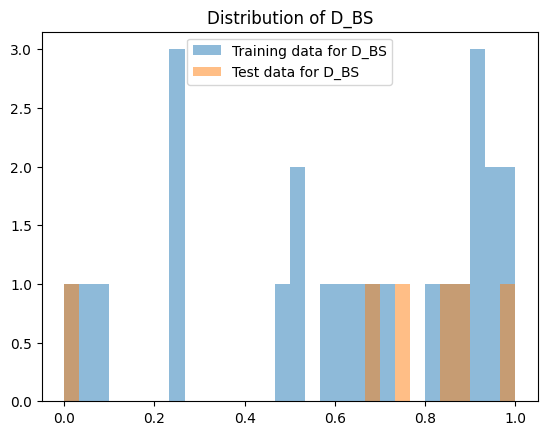

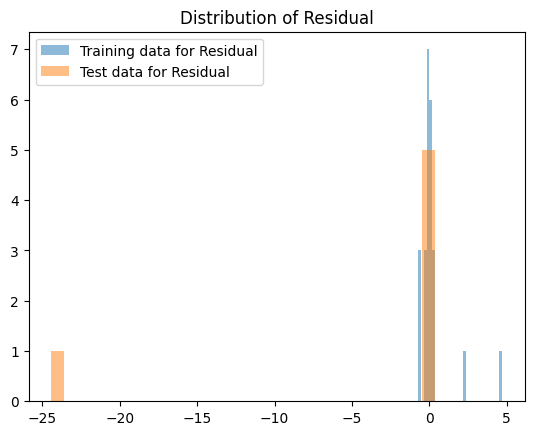

In [77]:
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")
# plot_train_test(y_train, y_test)

In [84]:
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # 3 to 6
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)  # 6 to 1

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x


input_size = 3
hidden_size = 6
output_size = 1

In [79]:
print(y.describe())

        Residual
count  30.000000
mean   -0.631289
std     4.602374
min   -24.437519
25%    -0.148515
50%     0.010997
75%     0.102103
max     4.706274


In [80]:
model = FNN(input_size, hidden_size, output_size)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)

y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

In [81]:
def train_model(model, epochs):
    patience = 5
    best_val_loss = float('inf')
    for epoch in range(epochs):

        print("Initial model weights:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"{name}: {param.data}")

        model.train()

        # Forward pass
        predictions_train = model(X_train)
        loss_train = loss_func(predictions_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}")

train_model(model, 2)  # Use this for hands-on



Initial model weights:
hidden.weight: tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090],
        [-0.4236,  0.5018,  0.1081],
        [ 0.4266,  0.0782,  0.2784],
        [-0.0815,  0.4451,  0.0853]])
hidden.bias: tensor([-0.2695,  0.1472, -0.2660, -0.0677, -0.2345,  0.3830])
output.weight: tensor([[-0.3223, -0.1882, -0.1153, -0.2455,  0.0385, -0.4032]])
output.bias: tensor([0.3687])
Epoch [1/2], Training Loss: 1.1911
Initial model weights:
hidden.weight: tensor([[ 0.4400,  0.4787, -0.1366],
        [ 0.5295, -0.1268,  0.1157],
        [-0.2812,  0.3389,  0.5089],
        [-0.4237,  0.5015,  0.1079],
        [ 0.4267,  0.0783,  0.2785],
        [-0.0833,  0.4445,  0.0837]])
hidden.bias: tensor([-0.2713,  0.1462, -0.2662, -0.0681, -0.2343,  0.3808])
output.weight: tensor([[-0.3216, -0.1848, -0.1151, -0.2451,  0.0404, -0.4005]])
output.bias: tensor([0.3740])
Epoch [2/2], Training Loss: 1.1840


'\n([[ 0.4414,  0.4792, -0.1353],\n        [ 0.5304, -0.1265,  0.1165],\n        [-0.2811,  0.3391,  0.5090],\n        [-0.4236,  0.5018,  0.1081],\n        [ 0.4266,  0.0782,  0.2784],\n        [-0.0815,  0.4451,  0.0853]])\n        '

In [83]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = loss_func(predictions, y_test)
    
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 99.1408


In [ ]:
'''
Initial weights

([[ 0.4414,  0.4792, -0.1353],
[ 0.5304, -0.1265,  0.1165],
[-0.2811,  0.3391,  0.5090],
[-0.4236,  0.5018,  0.1081],
[ 0.4266,  0.0782,  0.2784],
[-0.0815,  0.4451,  0.0853]])
        '''

In [ ]:
        # Batch training code
        
        # for start in range(0, len(X_shuffled), batch_size):
        #     end = start + batch_size
        #     X_batch = X_shuffled[start:end]
        #     y_batch = y_shuffled[start:end]
            
        #     # Forward pass
        #     predictions_train = model(X_batch)
        #     loss_train = loss_func(predictions_train, y_batch)
            
        #     # Backward pass
        #     optimizer.zero_grad()
        #     loss_train.backward()
        #     optimizer.step()
    
        # model.eval()
        # with torch.no_grad():  # Don't calculate gradient while validating
        #     predictions_val = model(X_val)
        #     loss_val = loss_func(predictions_val, y_val)
    
        # # Check for improvement
        # if loss_val < best_val_loss:
        #     best_val_loss = loss_val
        #     wait = 0
        # else:
        #     wait += 1
        #     if wait >= patience:
        #         print("Early stoppage")
        #         print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
        #         break
                
        # if (epoch + 1) % 5 == 0:

In [ ]:
        
        # indices = torch.randperm(len(X_train))
        # X_shuffled = X_train[indices]
        # y_shuffled = y_train[indices]
        
        # print(f"Manually Shuffled Features Tensor: {X_shuffled}")
        # print(f"Manually Shuffled Target Tensor: {y_shuffled}")